In [1]:
# 🚀 Install necessary libs
!pip install -q scipy tqdm h5py

import os
import urllib.request
import zipfile
import scipy.io as sio
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, layers
from skimage.transform import resize
from tqdm import tqdm
import matplotlib.pyplot as plt



In [ ]:

def load_shanghaitech_partB(root, split='train'):
    base = os.path.join(root, f"{split}_data")
    img_dir = os.path.join(base, "images")
    gt_dir = os.path.join(base, "ground_truth")

    X, Y = [], []

    for fname in tqdm(sorted(os.listdir(img_dir))):
        if not fname.lower().endswith(".jpg"):
            continue

        img_path = os.path.join(img_dir, fname)
        gt_path = os.path.join(gt_dir, "GT_" + fname[:-4] + ".mat")

        img = plt.imread(img_path).astype(np.float32) / 255.0

        mat = sio.loadmat(gt_path)
        points = mat["image_info"][0][0][0][0]

    
        points = np.array(points)


        if points.size == 0:
            points = np.empty((0, 2))  
        elif points.ndim == 0:
          
            points = np.empty((0, 2))
        elif points.ndim == 1:
            if points.size == 2:
               
                points = points.reshape(1, 2)
            else:
               
                points = np.empty((0, 2))
        elif points.ndim == 3:
        
            points = points.reshape(-1, 2)
        else:
            
            points = np.empty((0, 2))

        h, w = img.shape[:2]
        den = np.zeros((h, w), dtype=np.float32)

        for x, y in points:
            xi, yi = min(w - 1, int(x)), min(h - 1, int(y))
            den[yi, xi] = 1

        den = resize(den, (h // 4, w // 4), order=1, preserve_range=True, anti_aliasing=False)
        den = den[..., np.newaxis]

        X.append(img)
        Y.append(den)

    return X, Y


In [ ]:

def build_mcnn():
    inp = layers.Input(shape=(None, None, 3))

    def tower(filters):
        x = layers.Conv2D(filters, 9 if filters==16 else 7 if filters==32 else 5, activation='relu', padding='same')(inp)
        x = layers.MaxPooling2D(pool_size=2)(x)  # halves size
        x = layers.Conv2D(filters*2, 7 if filters==16 else 5 if filters==32 else 3, activation='relu', padding='same')(x)
        x = layers.MaxPooling2D(pool_size=2)(x)  # halves size again, total 1/4 input size
        return x

    t1 = tower(16)
    t2 = tower(32)
    t3 = tower(64)

    x = layers.Concatenate()([t1, t2, t3])
    out = layers.Conv2D(1, 1, activation=None, padding='same')(x)

    return Model(inputs=inp, outputs=out)

In [ ]:
def build_unet():
    base = tf.keras.applications.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(None, None, 3)
    )

    skip = [
        base.get_layer('block_1_expand_relu').output, 
        base.get_layer('block_3_expand_relu').output,  
        base.get_layer('block_6_expand_relu').output,  
        base.get_layer('block_13_expand_relu').output, 
    ]

    x = base.output 

    def conv_up(x, skip_feature, filters):
        x = layers.UpSampling2D()(x)
        x = layers.Concatenate()([x, skip_feature])
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
        x = layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
        return x

    x = conv_up(x, skip[3], 256)
    x = conv_up(x, skip[2], 128)
    x = conv_up(x, skip[1], 64)

    x = layers.Conv2D(1, 1, activation=None, padding='same')(x)
    return Model(inputs=base.input, outputs=x)


In [5]:
def mae_mse(y_true, y_pred):
    y_true_c = tf.reduce_sum(y_true, axis=[1,2,3])
    y_pred_c = tf.reduce_sum(y_pred, axis=[1,2,3])
    mae = tf.reduce_mean(tf.abs(y_true_c - y_pred_c))
    mse = tf.sqrt(tf.reduce_mean(tf.pow(y_true_c - y_pred_c, 2)))
    return mae, mse



In [6]:
def train_model(model, X, Y, epochs=5):
    opt = tf.keras.optimizers.Adam(1e-4)
    for ep in range(epochs):
        mae_list, mse_list = [], []
        for img, dens in zip(X, Y):
            with tf.GradientTape() as tape:
                pred = model(tf.expand_dims(img,0), training=True)
                loss = tf.reduce_mean(tf.square(pred - dens))
            grads = tape.gradient(loss, model.trainable_variables)
            opt.apply_gradients(zip(grads, model.trainable_variables))
            m, s = mae_mse(dens[None], pred)
            mae_list.append(m); mse_list.append(s)
        print(f"Epoch {ep+1}/{epochs} — MAE: {np.mean(mae_list):.3f}, MSE: {np.mean(mse_list):.3f}")
    return model

In [7]:
def eval_model(model, X, Y):
    maes, mses = [], []
    for img, dens in zip(X, Y):
        pred = model(tf.expand_dims(img,0), training=False)
        m, s = mae_mse(dens[None], pred)
        maes.append(m); mses.append(s)
    return np.mean(maes), np.mean(mses)


In [ ]:
def visualize_prediction(model, X, Y, num=3):
    for i in range(num):
        img = X[i]
        gt_density = Y[i]
        pred_density = model(tf.expand_dims(img, 0), training=False)[0].numpy()

        plt.figure(figsize=(15, 4))

        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(pred_density[:, :, 0], cmap='jet')
        plt.title(f"Pred Count: {np.sum(pred_density):.1f}")
        plt.axis("off")

        plt.show()


In [ ]:

root_path = '/content/data/part_B_final'
Xtr, Ytr = load_shanghaitech_partB(root_path, split='train')
Xte, Yte = load_shanghaitech_partB(root_path, split='test')

100%|██████████| 316/316 [00:04<00:00, 63.45it/s]


In [18]:
mcnn = build_mcnn()
print("Training MCNN:")
train_model(mcnn, Xtr, Ytr, epochs=5)
m_mae, m_mse = eval_model(mcnn, Xte, Yte)
print("MCNN — MAE:", m_mae, "MSE:", m_mse)

Training MCNN:
Epoch 1/5 — MAE: 110.796, MSE: 110.796
Epoch 2/5 — MAE: 45.465, MSE: 45.465
Epoch 3/5 — MAE: 41.965, MSE: 41.965
Epoch 4/5 — MAE: 28.160, MSE: 28.160
Epoch 5/5 — MAE: 37.956, MSE: 37.956
MCNN — MAE: 22.256775 MSE: 22.256775


In [23]:
unet = build_unet()
print("Training U-Net:")
train_model(unet, Xtr, Ytr, epochs=5)
u_mae, u_mse = eval_model(unet, Xte, Yte)
print("U-Net — MAE:", u_mae, "MSE:", u_mse)

/tmp/ipython-input-22-3183124792.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training U-Net:
Epoch 1/5 — MAE: 958.722, MSE: 958.722
Epoch 2/5 — MAE: 104.267, MSE: 104.267
Epoch 3/5 — MAE: 60.871, MSE: 60.871
Epoch 4/5 — MAE: 68.984, MSE: 68.984
Epoch 5/5 — MAE: 69.667, MSE: 69.667
U-Net — MAE: 13.487725 MSE: 13.487725


In [24]:
print(f"Comparison:\nModel\tMAE\tMSE\nMCNN\t{m_mae:.2f}\t{m_mse:.2f}\nU-Net\t{u_mae:.2f}\t{u_mse:.2f}")

Comparison:
Model	MAE	MSE
MCNN	22.26	22.26
U-Net	13.49	13.49


MCNN — MAE: 22.256775 MSE: 22.256775


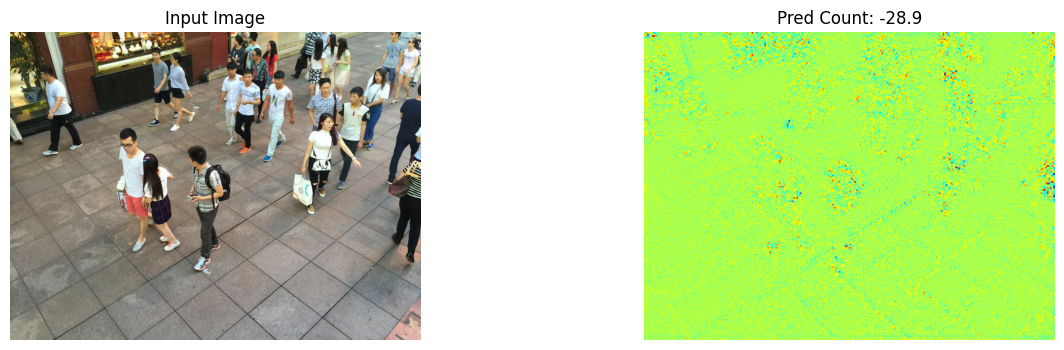

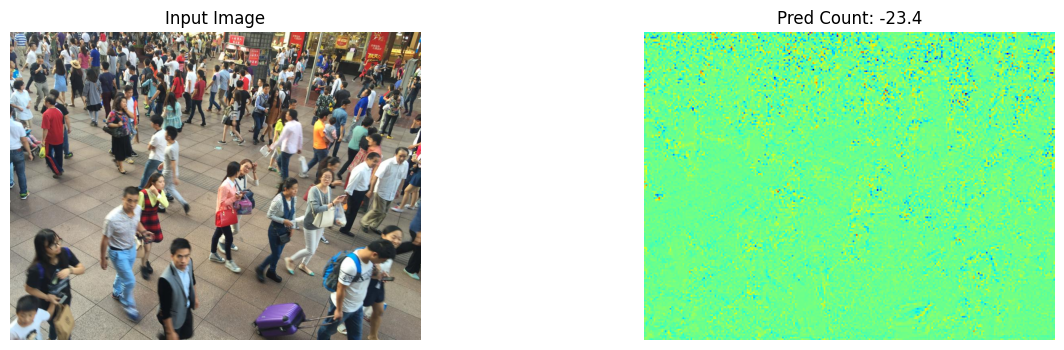

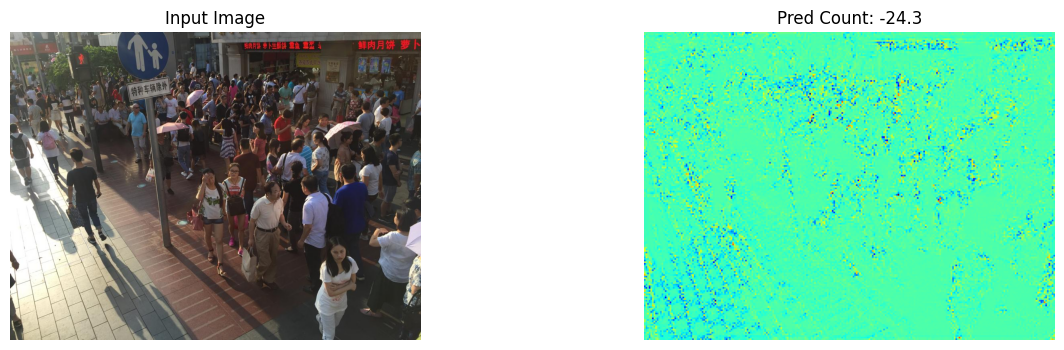

In [32]:
m_mae, m_mse = eval_model(mcnn, Xte, Yte)
print("MCNN — MAE:", m_mae, "MSE:", m_mse)
visualize_prediction(mcnn, Xte, Yte)


U-Net — MAE: 13.487725 MSE: 13.487725


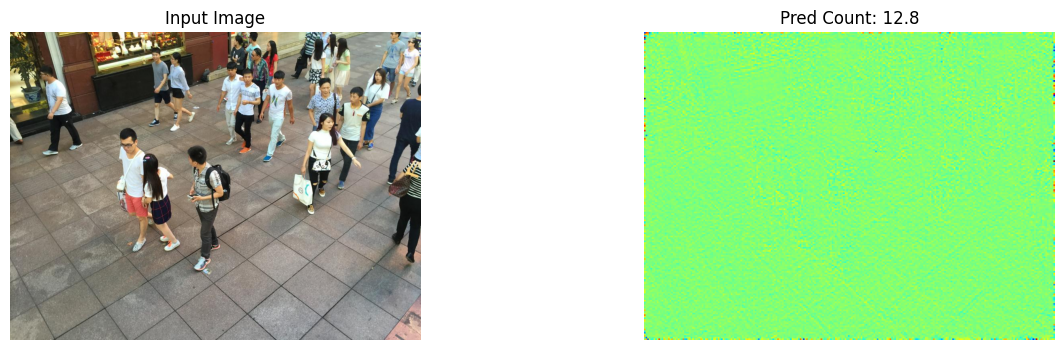

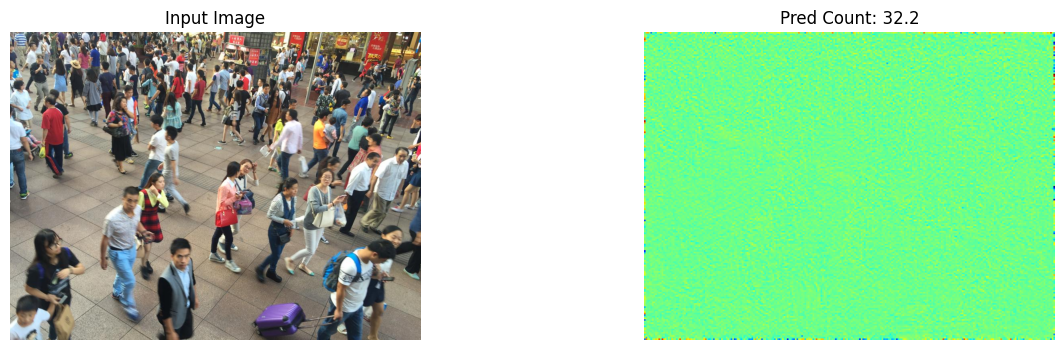

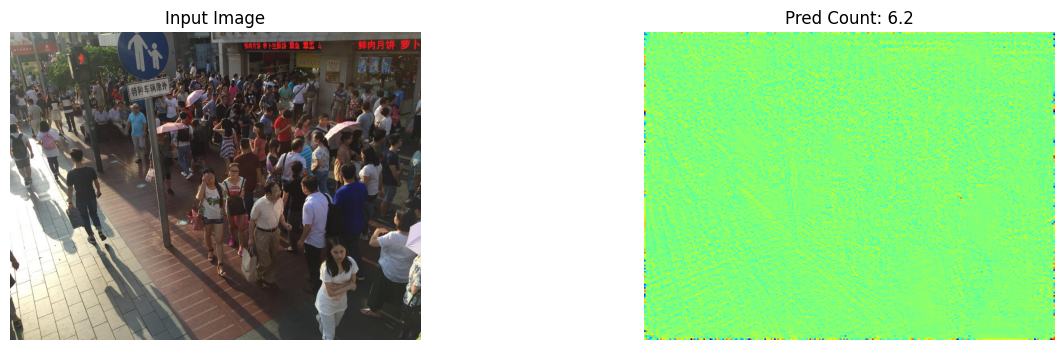

In [33]:
u_mae, u_mse = eval_model(unet, Xte, Yte)
print("U-Net — MAE:", u_mae, "MSE:", u_mse)
visualize_prediction(unet, Xte, Yte)
